In [1]:
import cv2
import numpy as np
from pathlib import Path

from utils import plot_imgs
from jointrecog.experiment import _init_graph
from jointrecog.settings import EXPER_PATH
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/rpg_students/moritz/sp-recognition/env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
config = {
    'data': {
        'name': 'kaggle_rhd',
        'validation_size': 500,
        'disk_radius': 8,
    },
    'model': {
        'name': 'resnet_disks',
        'batch_size': 25,
        'learning_rate': 0.0001,
        'output_kernel': 3,
    }
}
exper_dir = Path(EXPER_PATH, 'resnet_disks_1605').as_posix()
print(exper_dir)

/media/scratch/moritz/sp-recognition/experiments/resnet_disks_1605


In [31]:
def draw_keypoints(img, kp, color=(0, 255, 0)): 
    keypoint = [cv2.KeyPoint(kp[1], kp[0], 1)]
    output = cv2.drawKeypoints(img.astype(np.uint8), keypoint, None, color=color)
    return output

In [32]:
def draw_disk(img, kp, color=(255, 0, 0)):
    output = img
    cv2.circle(output, (kp[1], kp[0]), config['data']['disk_radius'], color)
    return output

In [33]:
def process_logits(logits):
    activation = cv2.cvtColor(logits, cv2.COLOR_GRAY2RGB)
    activation[:, :, 0] = 0
    activation[:, :, 1] = 0
    return activation

[05/17/2018 12:20:50 INFO] Number of GPUs detected: 1


[]


[05/17/2018 12:21:06 INFO] Restoring parameters from /media/scratch/moritz/sp-recognition/experiments/resnet_disks_1605/model.ckpt-79714
/home/rpg_students/moritz/sp-recognition/env/lib/python3.5/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


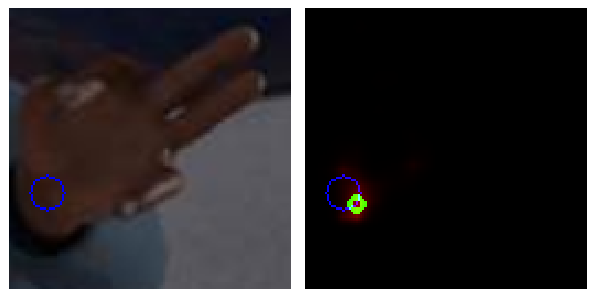

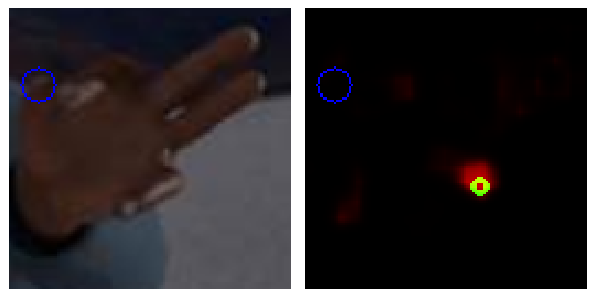

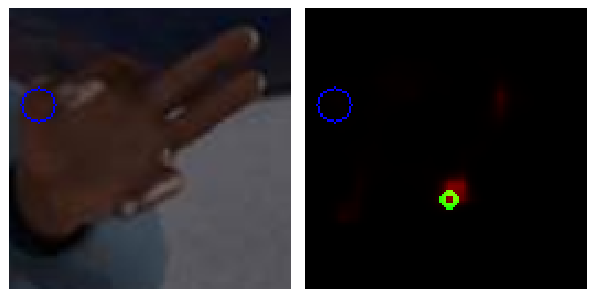

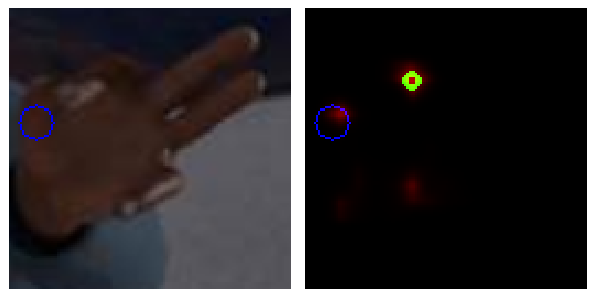

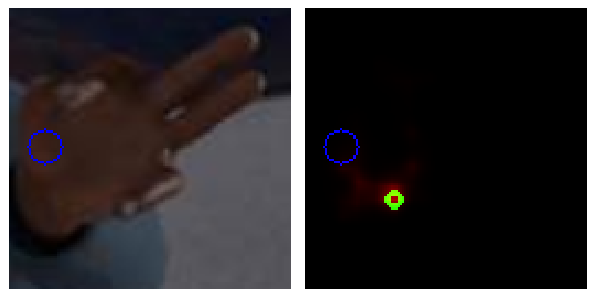

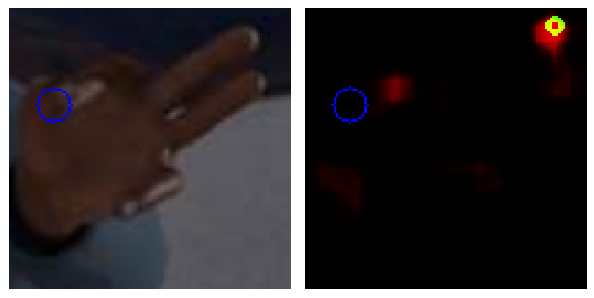

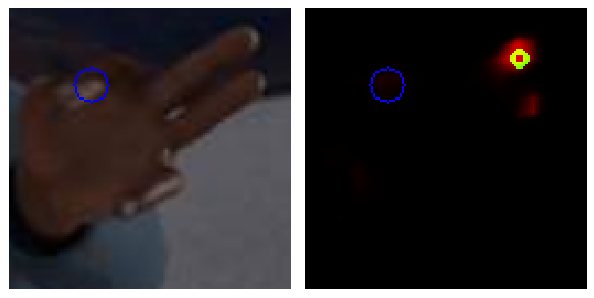

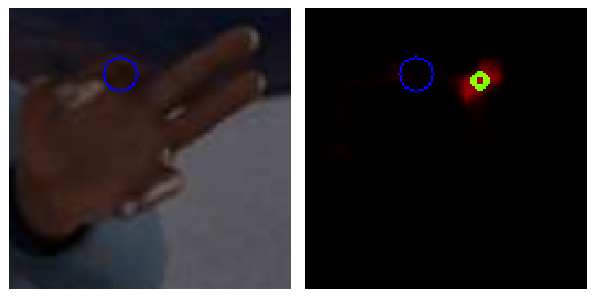

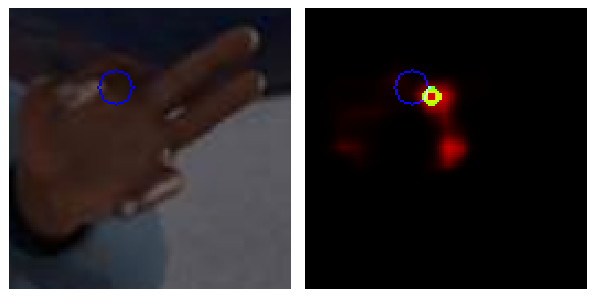

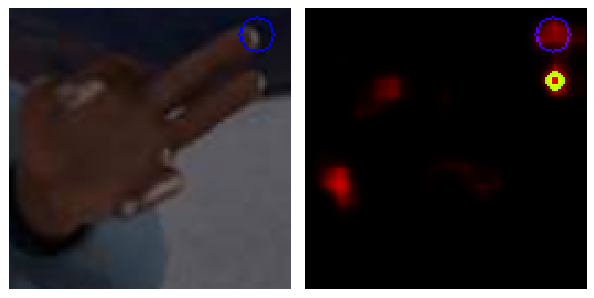

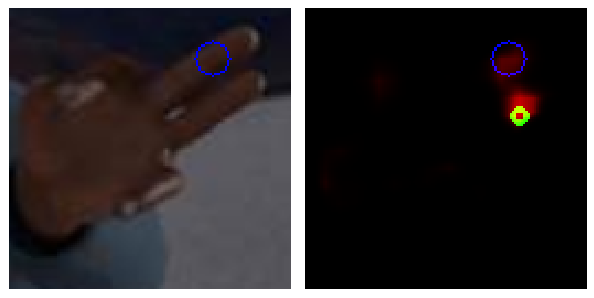

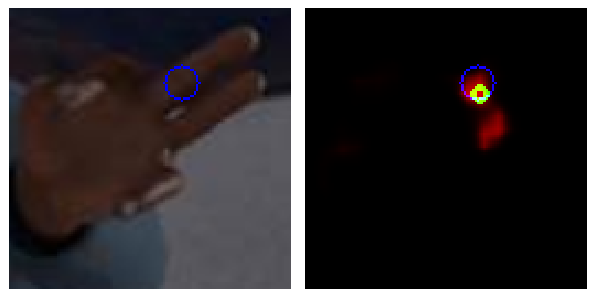

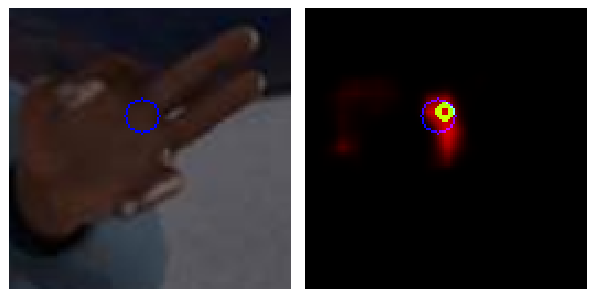

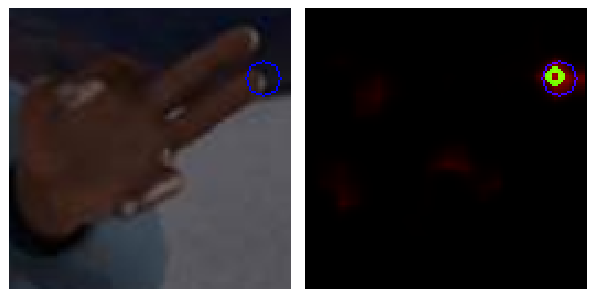

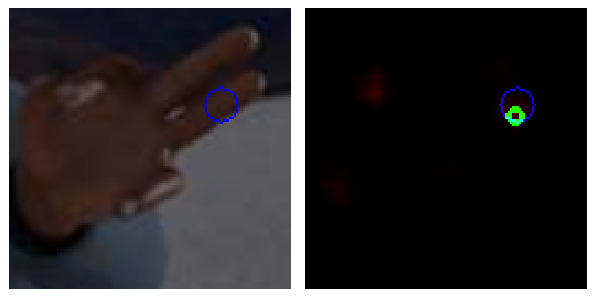

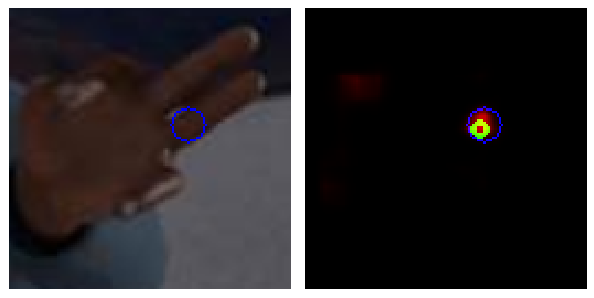

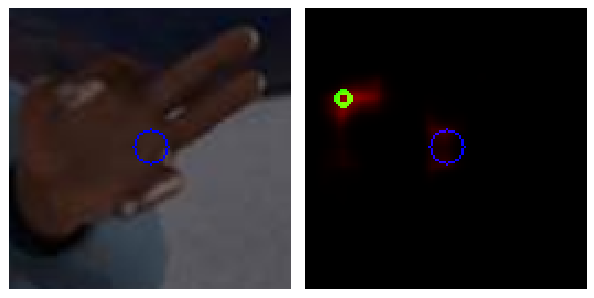

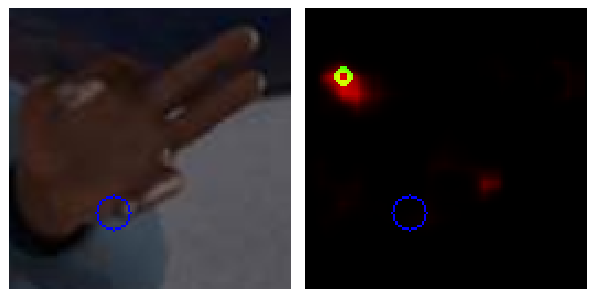

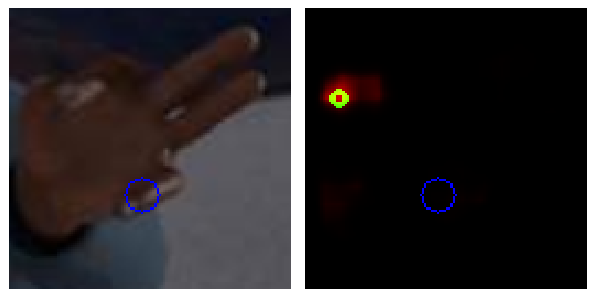

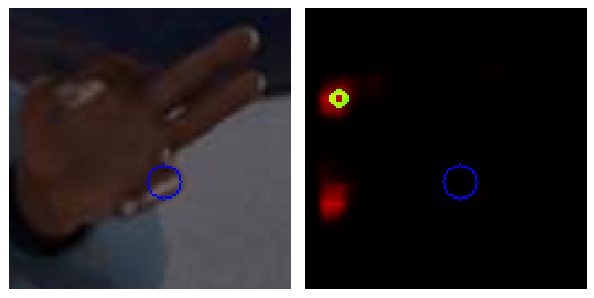

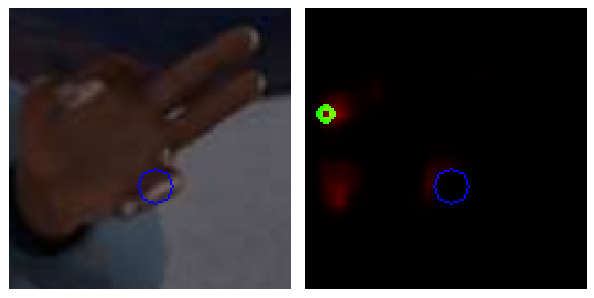

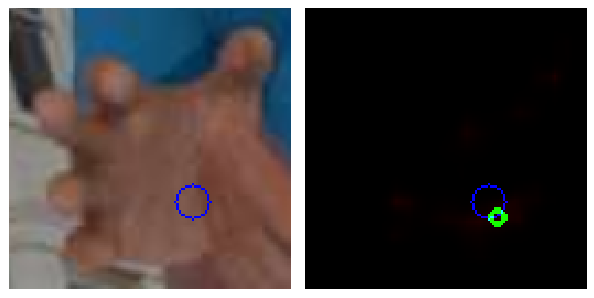

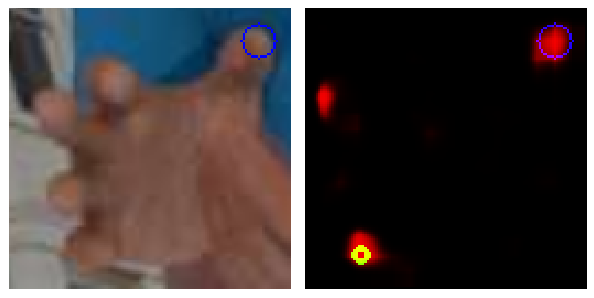

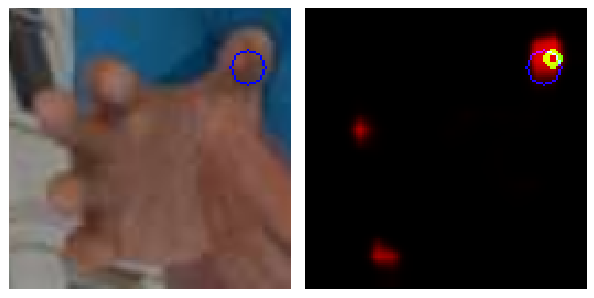

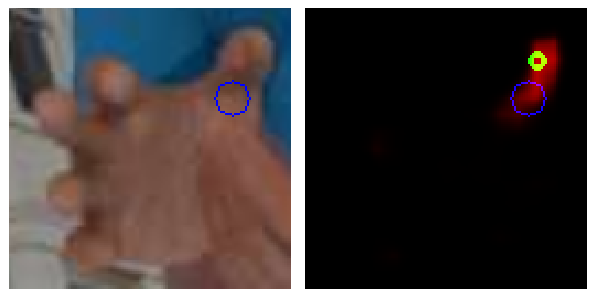

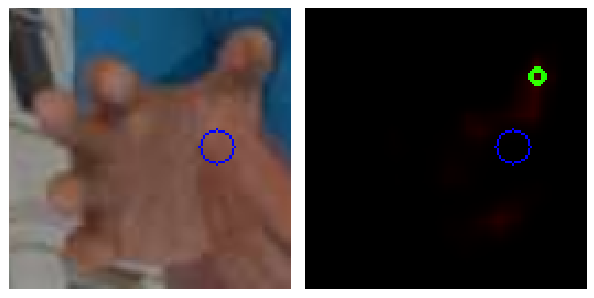

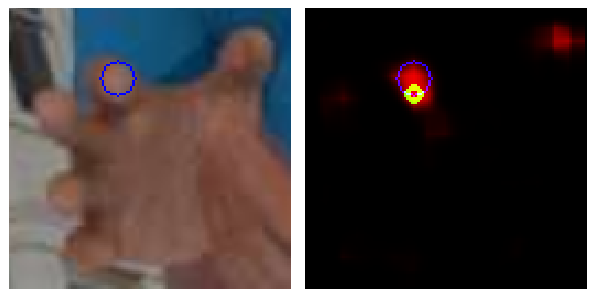

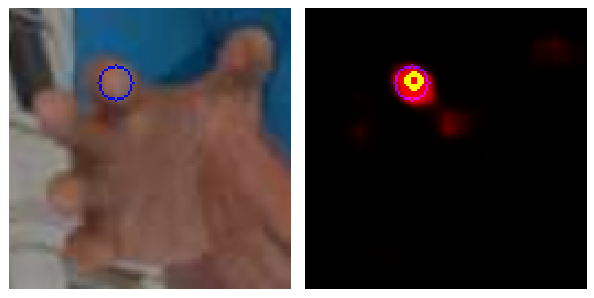

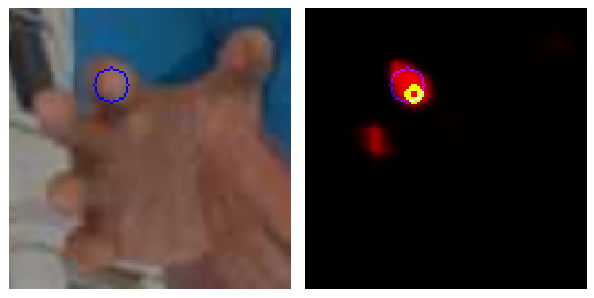

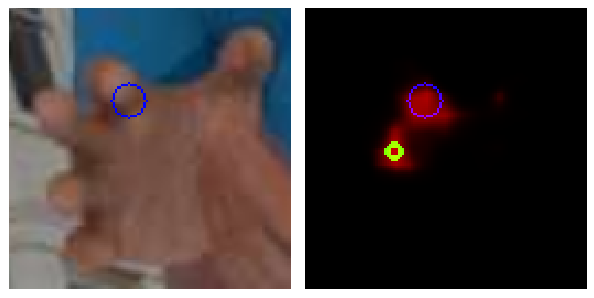

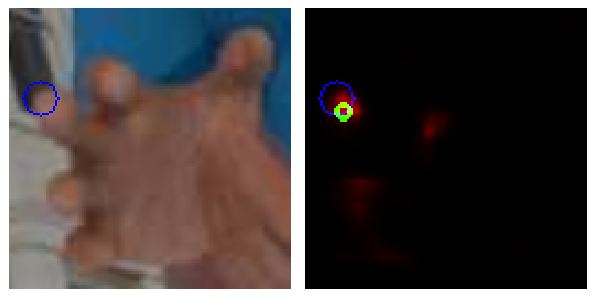

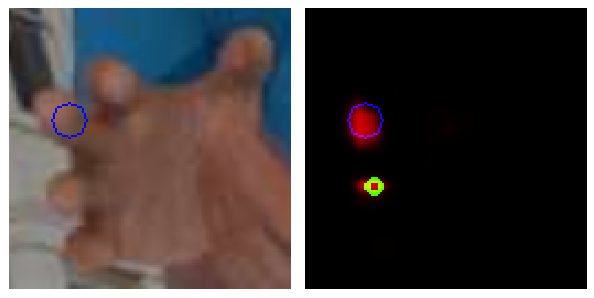

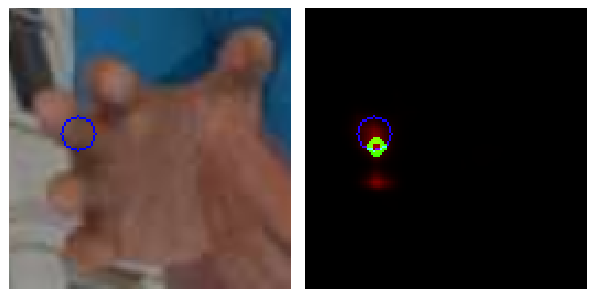

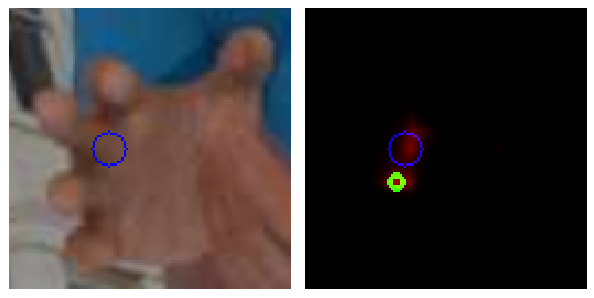

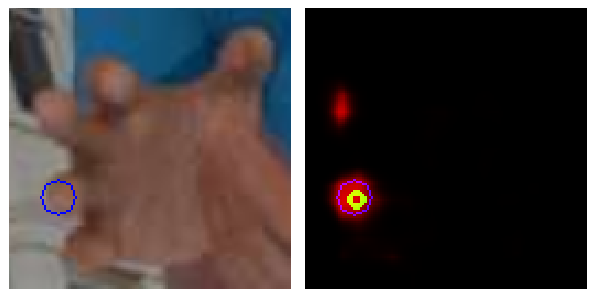

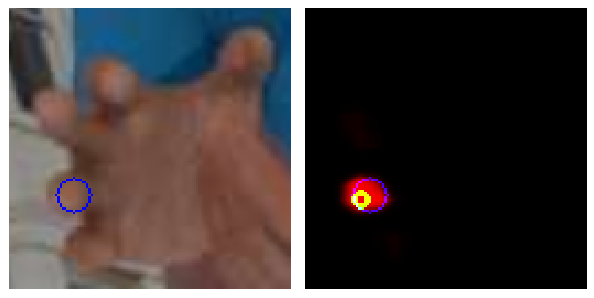

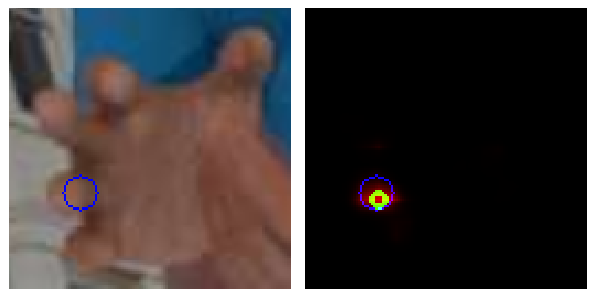

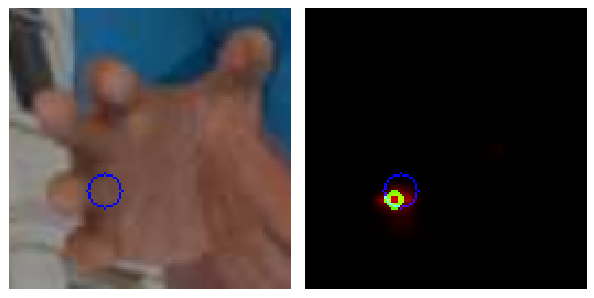

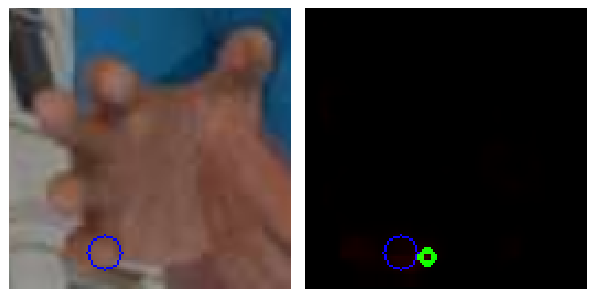

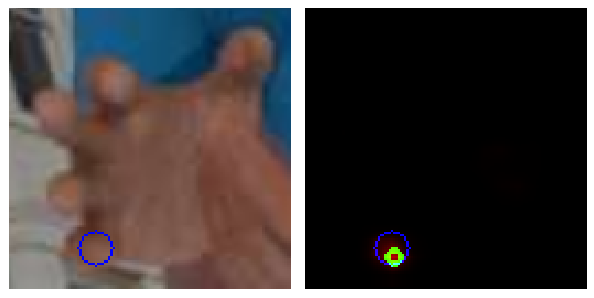

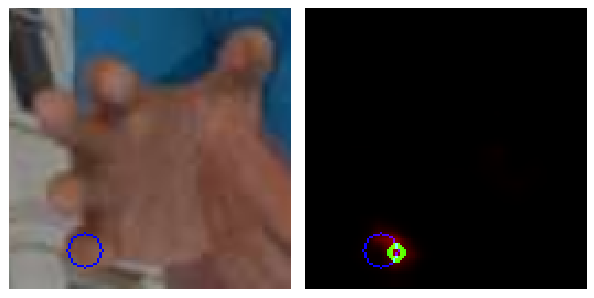

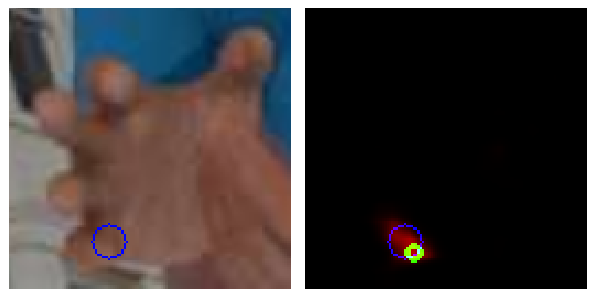

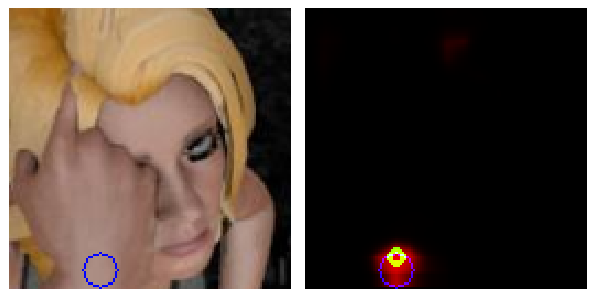

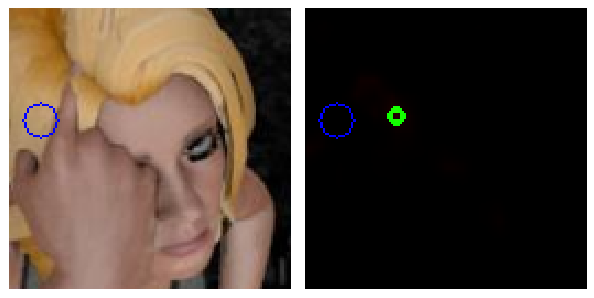

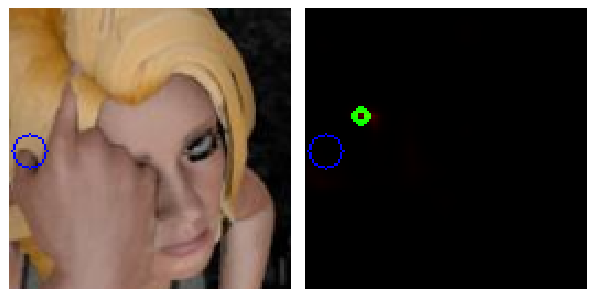

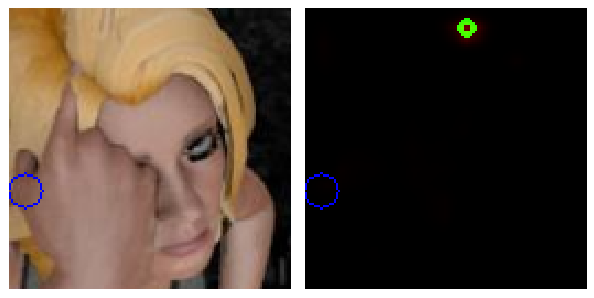

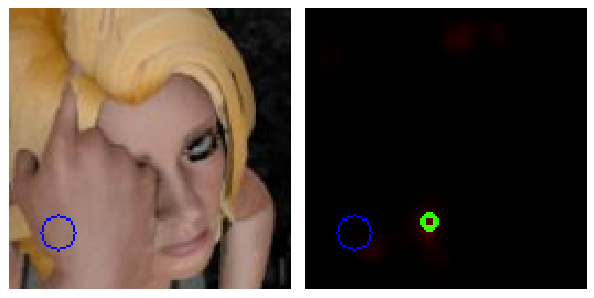

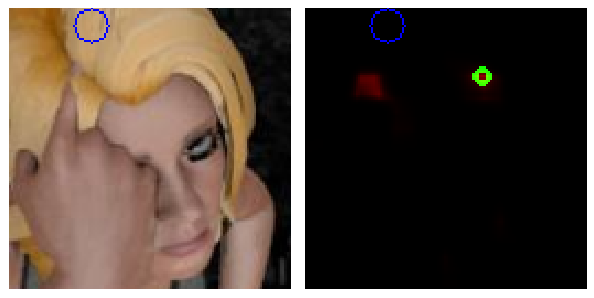

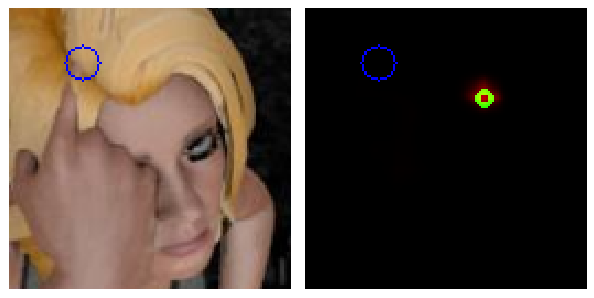

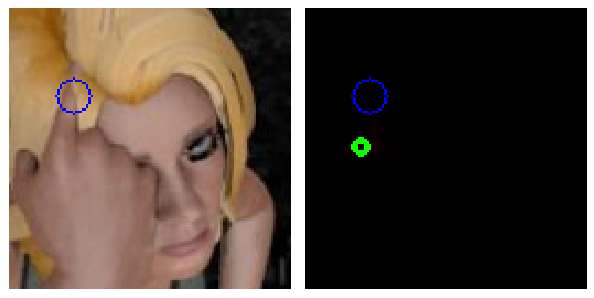

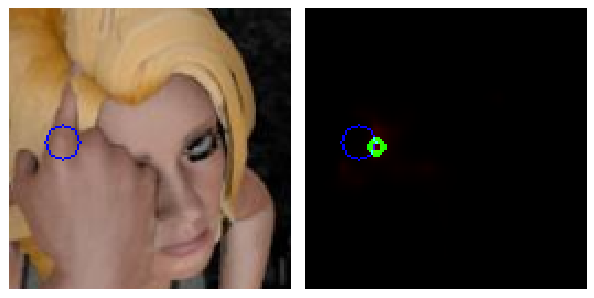

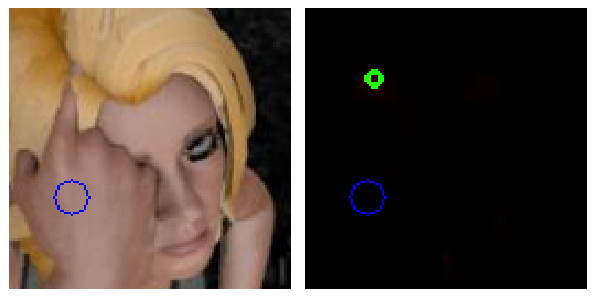

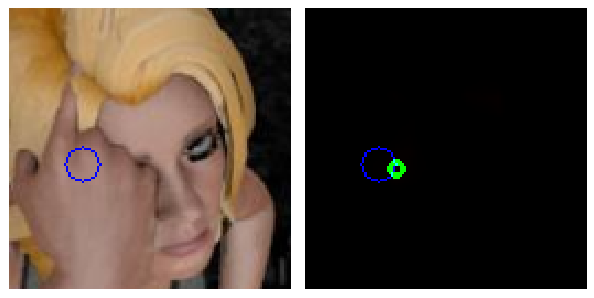

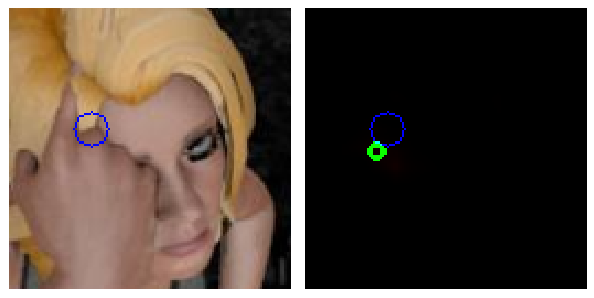

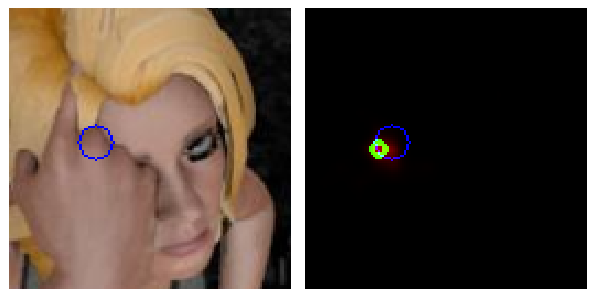

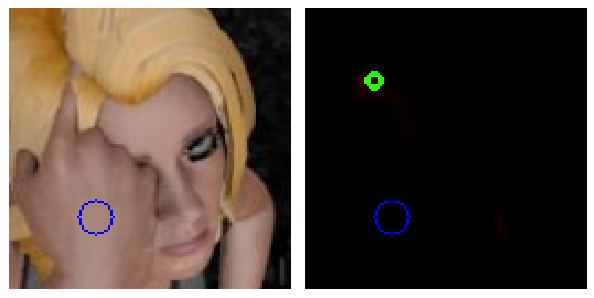

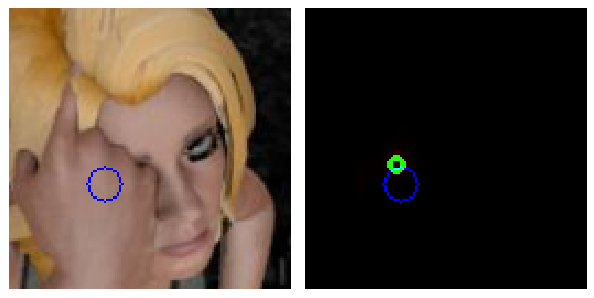

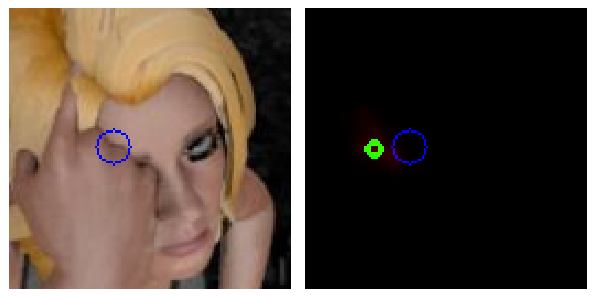

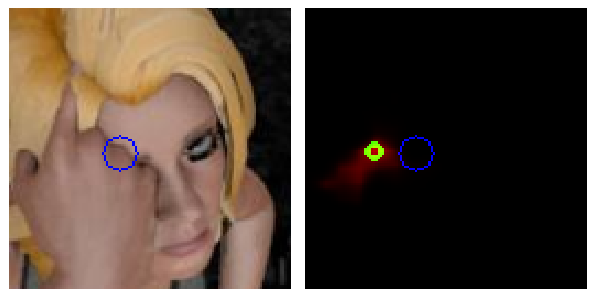

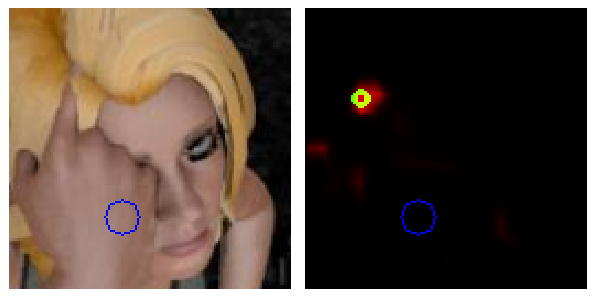

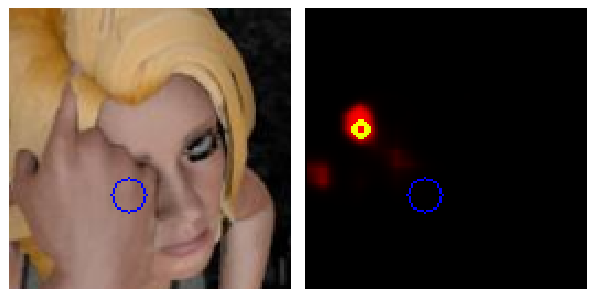

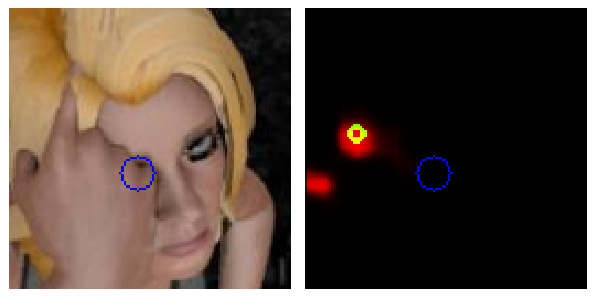

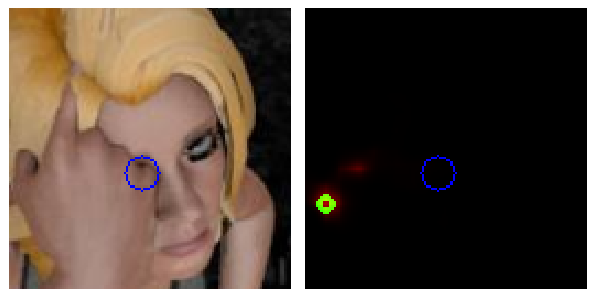

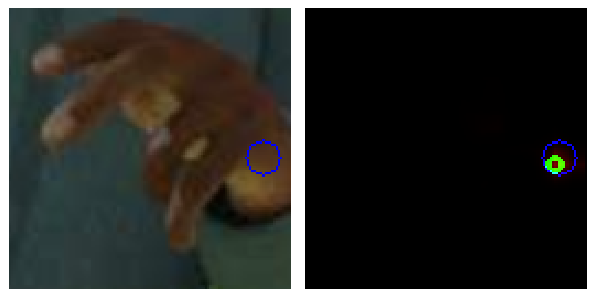

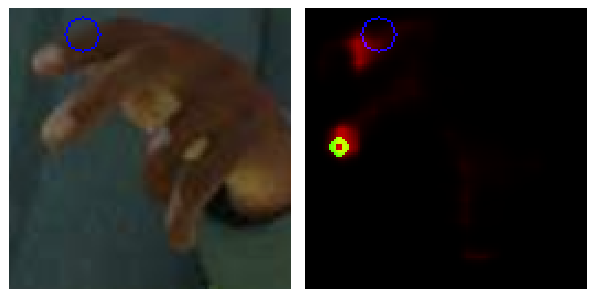

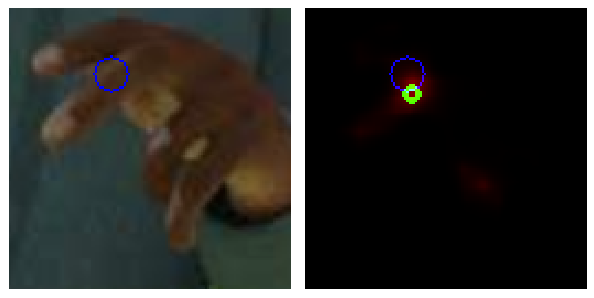

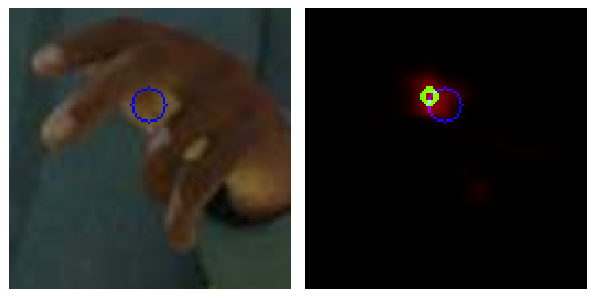

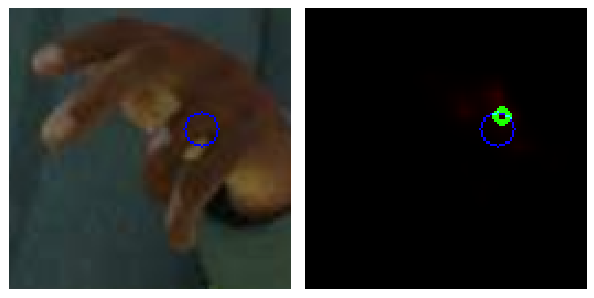

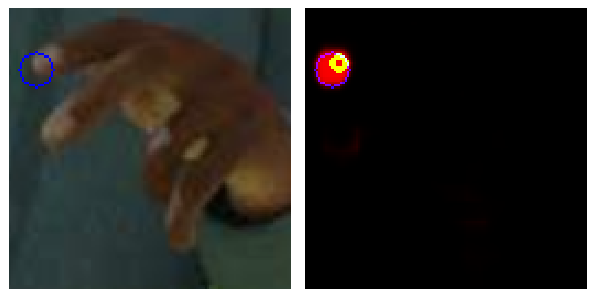

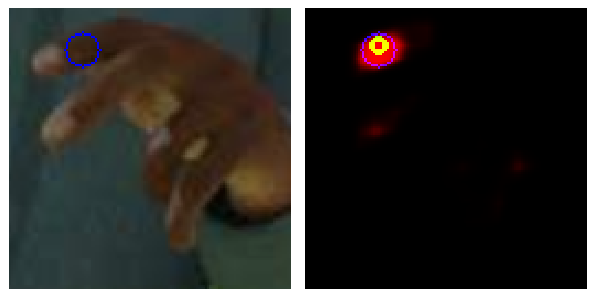

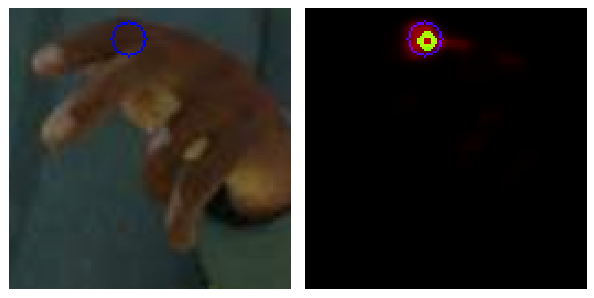

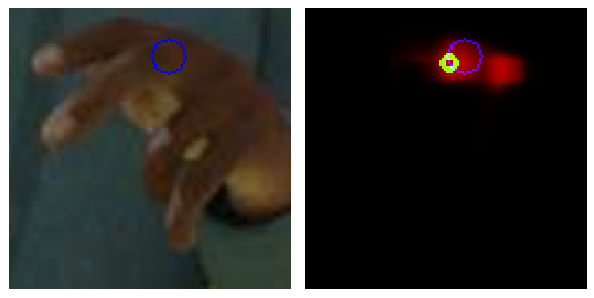

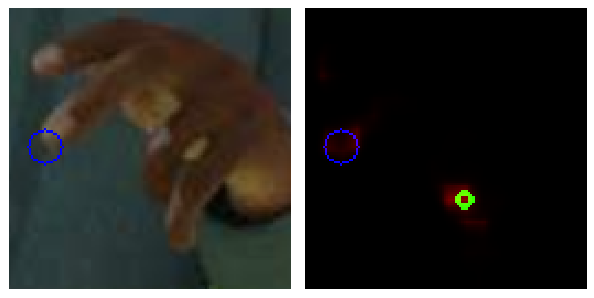

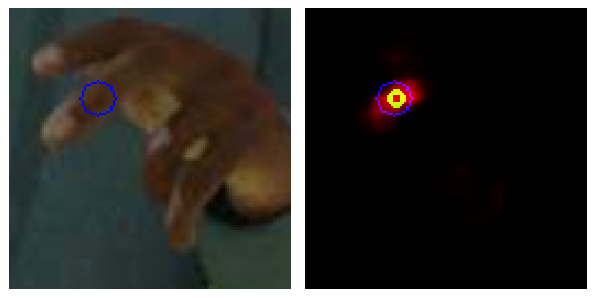

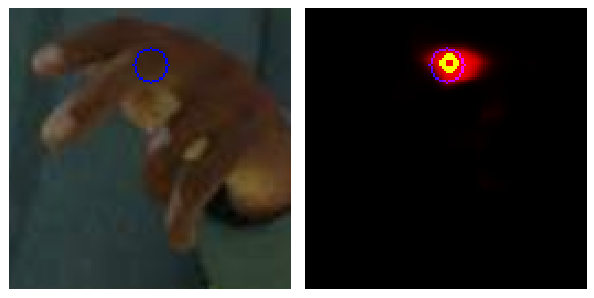

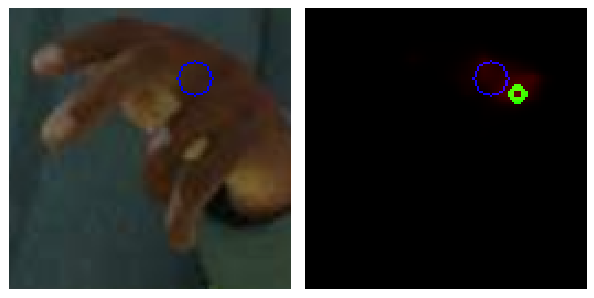

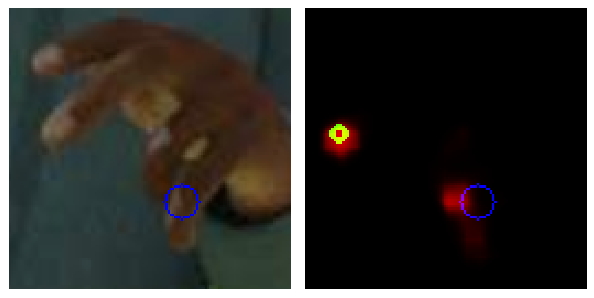

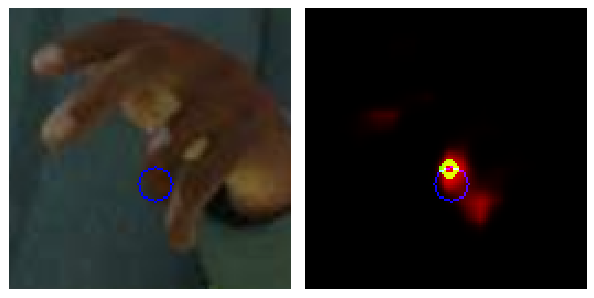

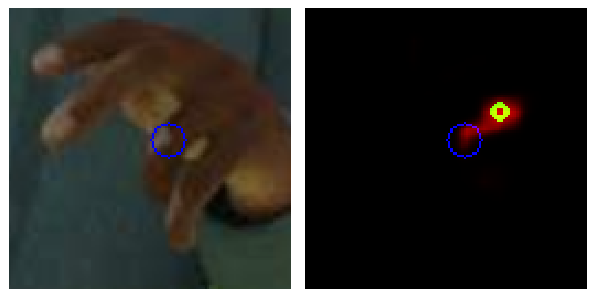

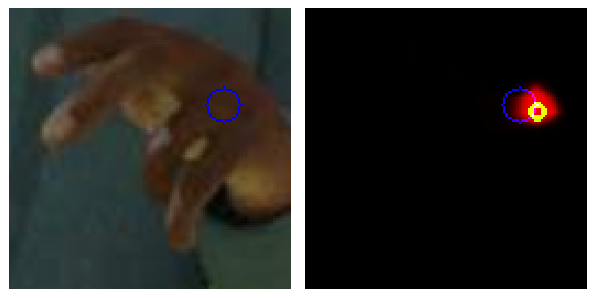

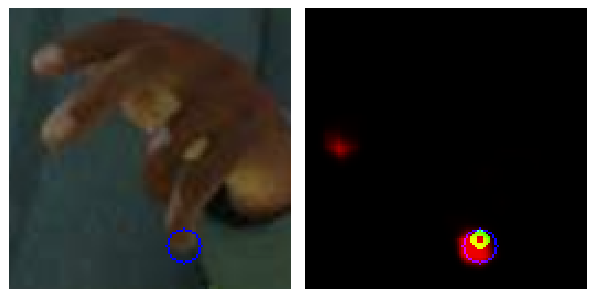

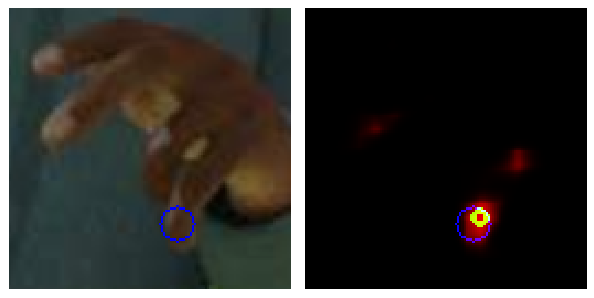

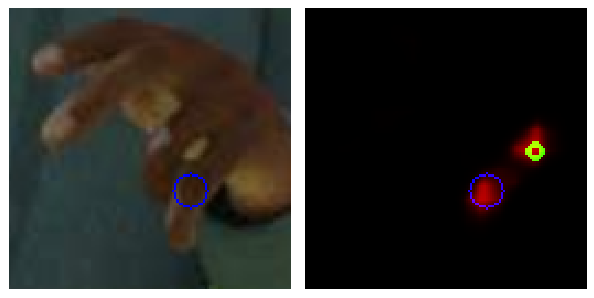

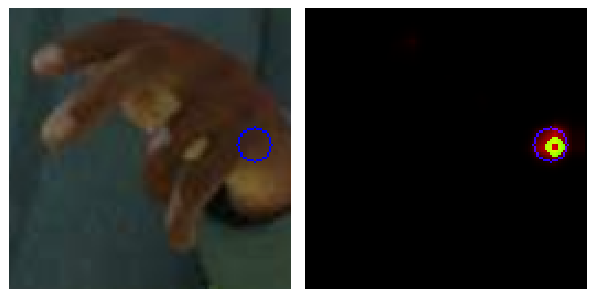

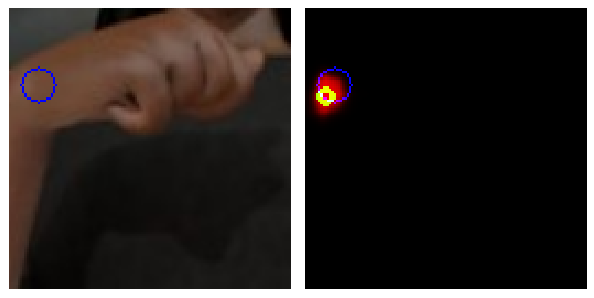

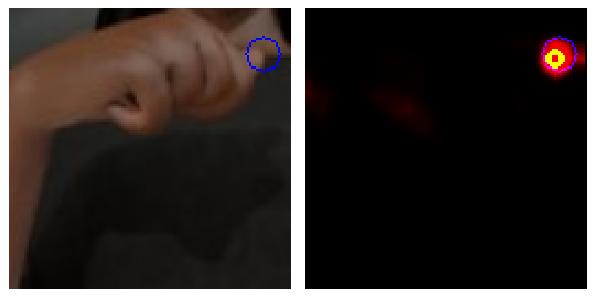

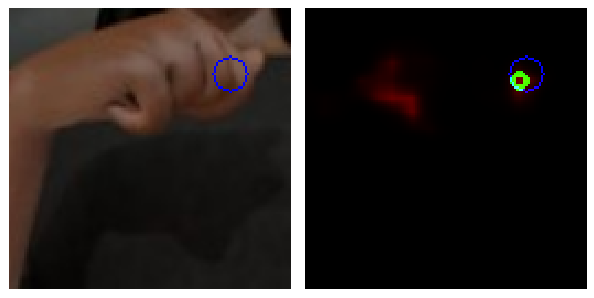

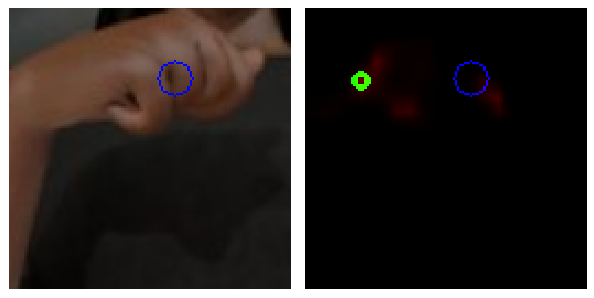

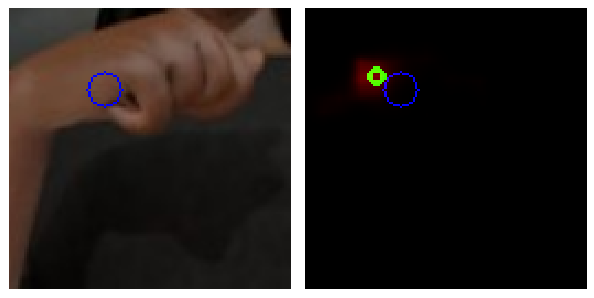

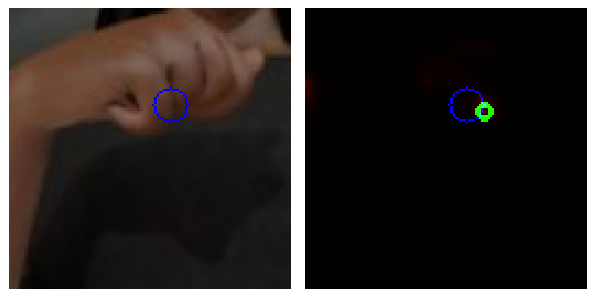

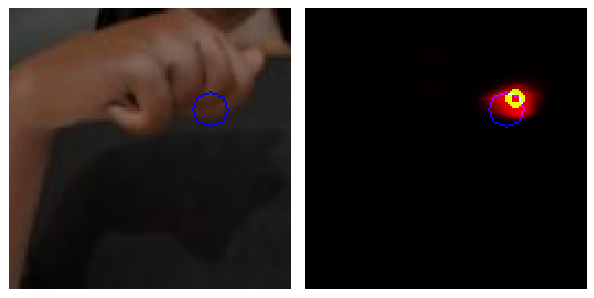

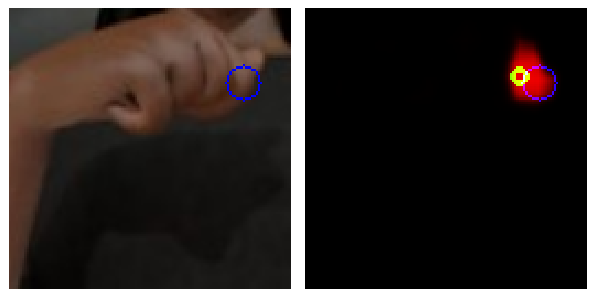

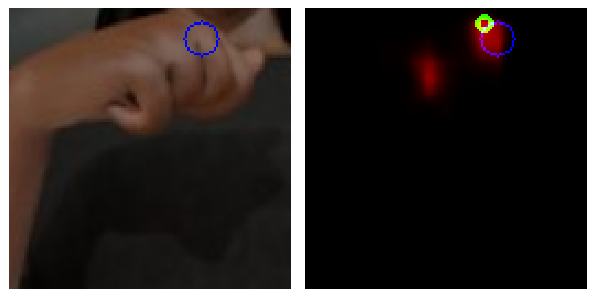

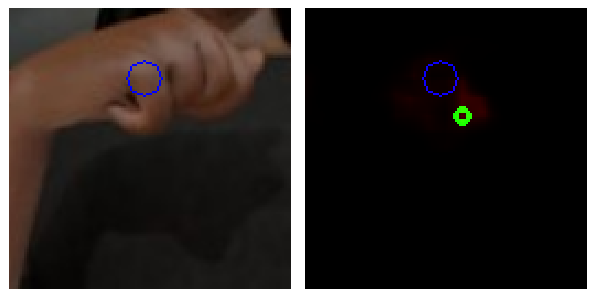

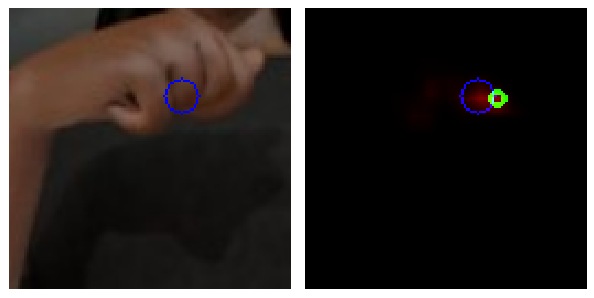

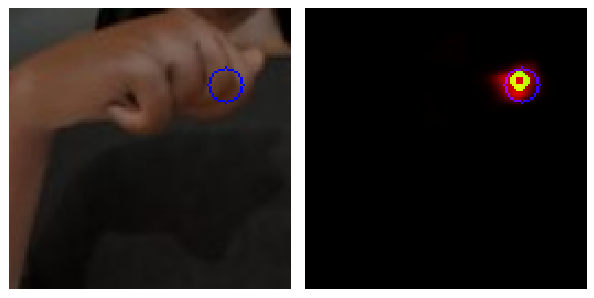

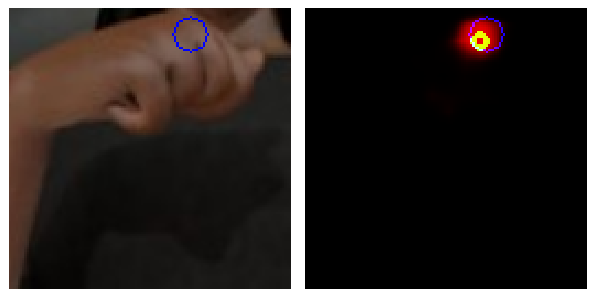

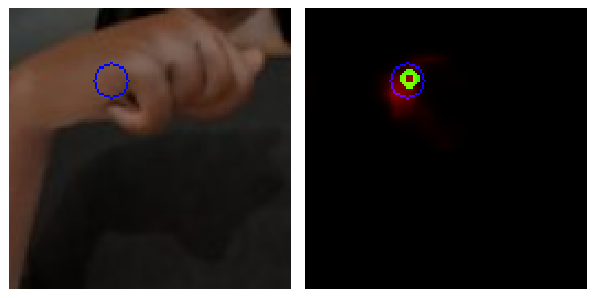

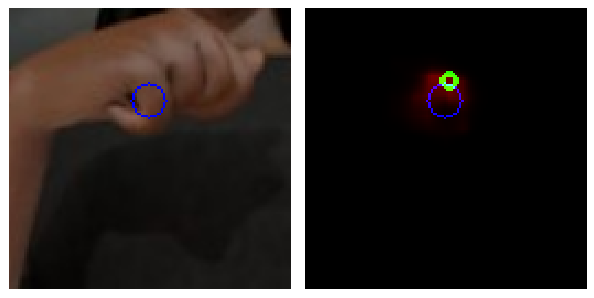

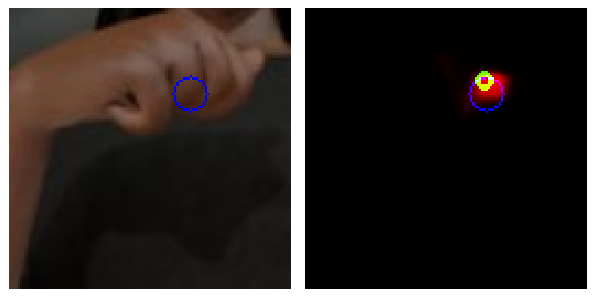

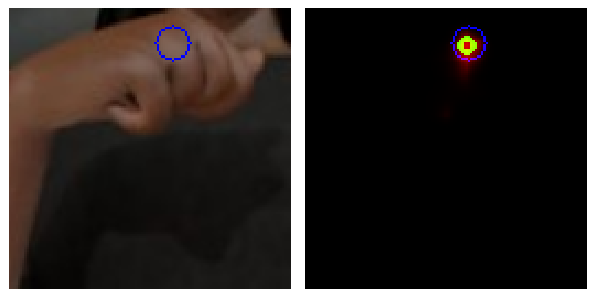

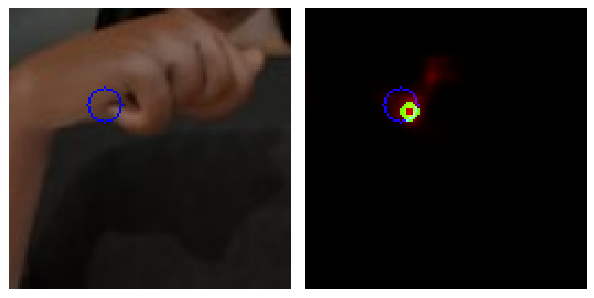

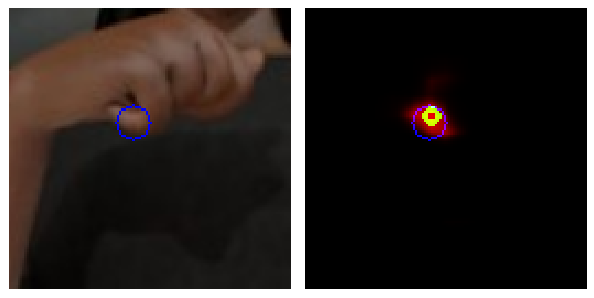

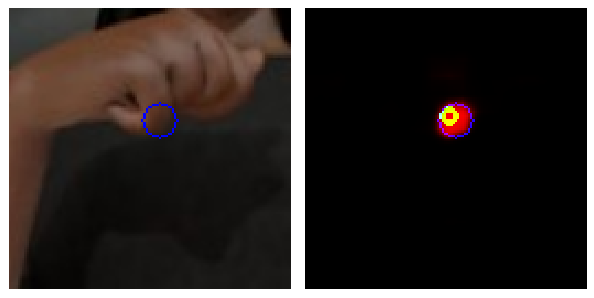

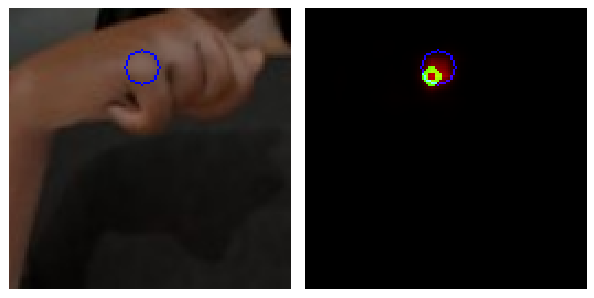

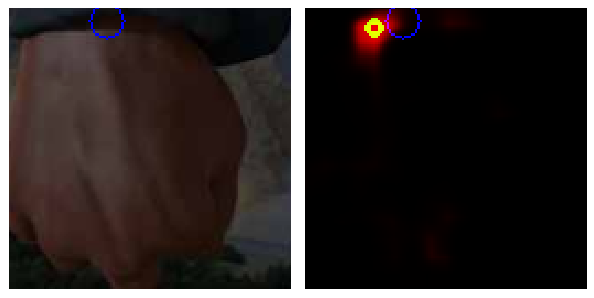

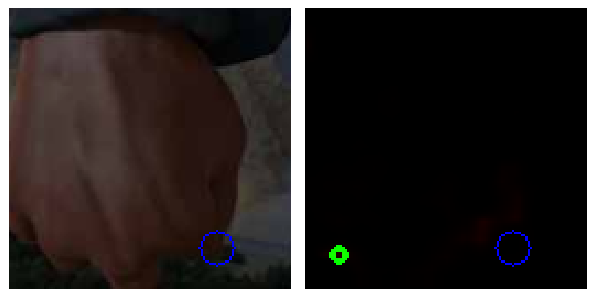

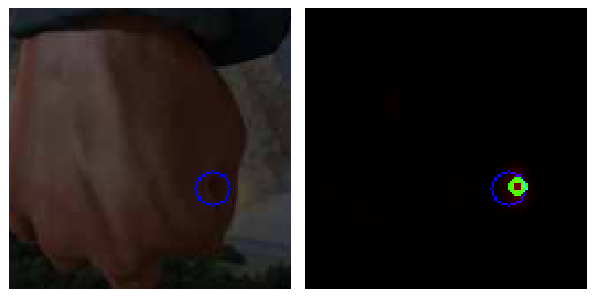

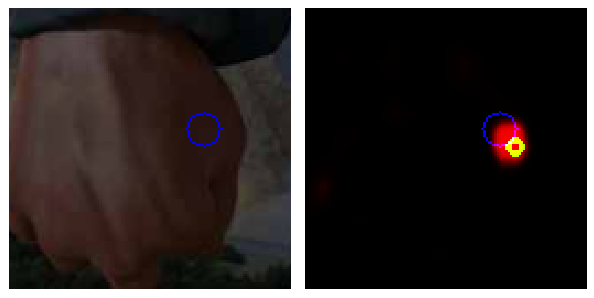

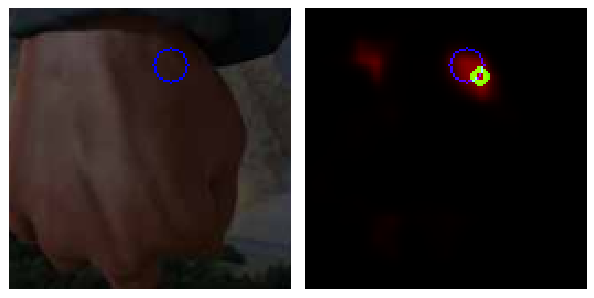

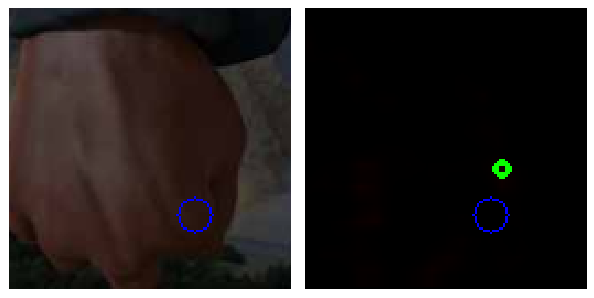

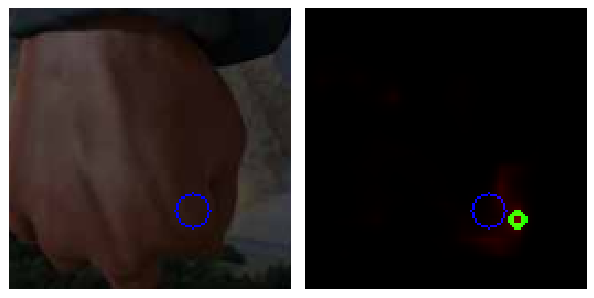

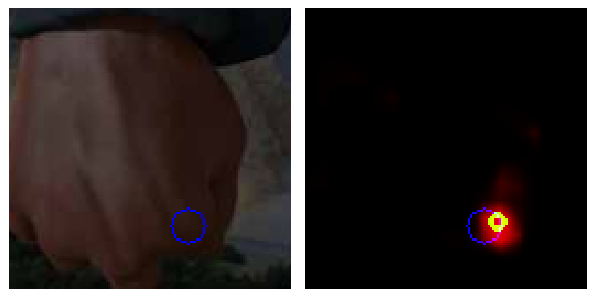

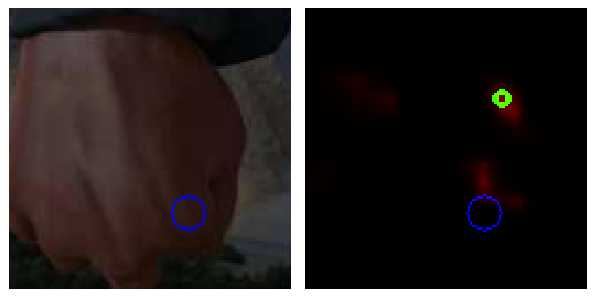

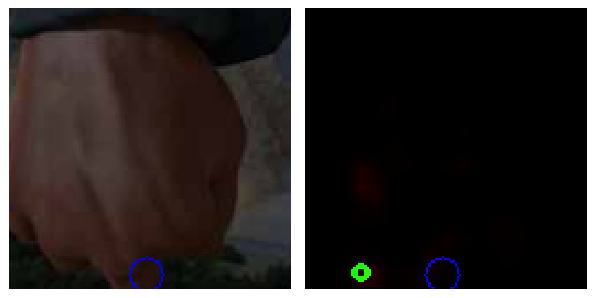

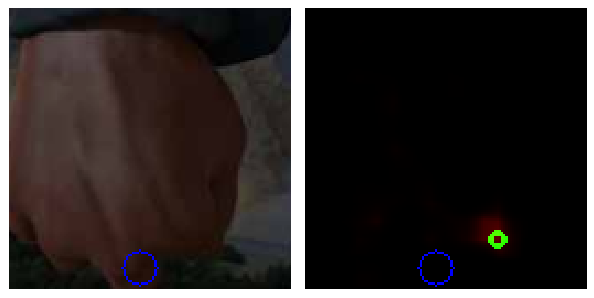

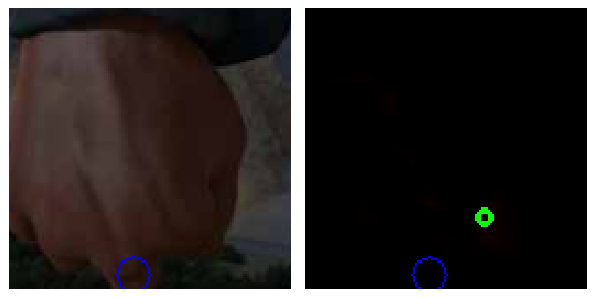

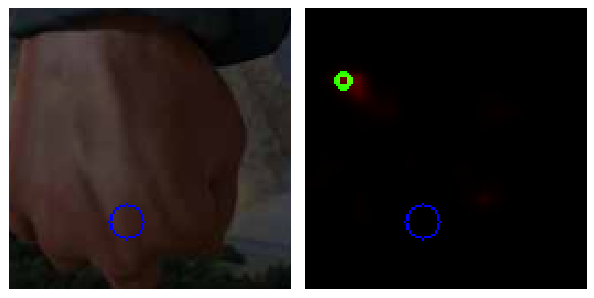

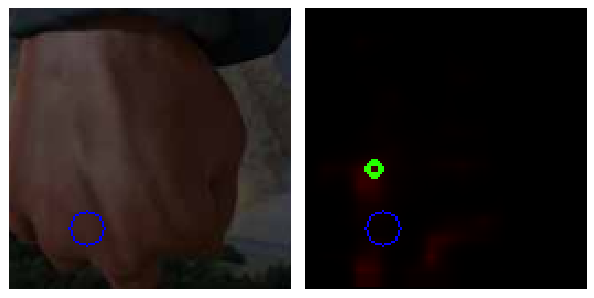

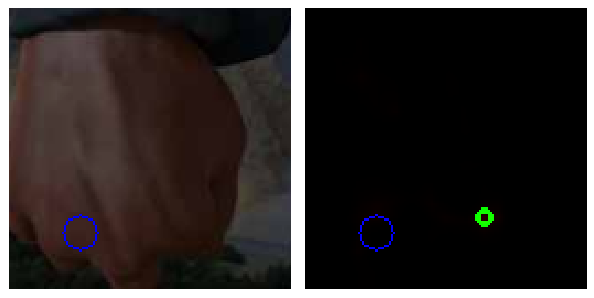

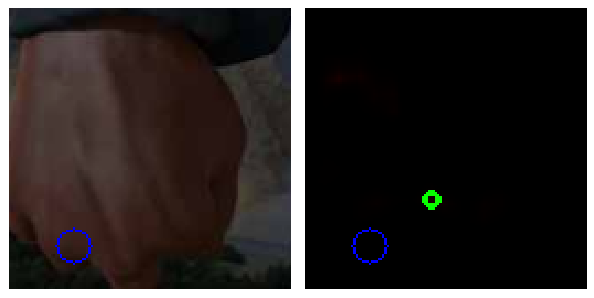

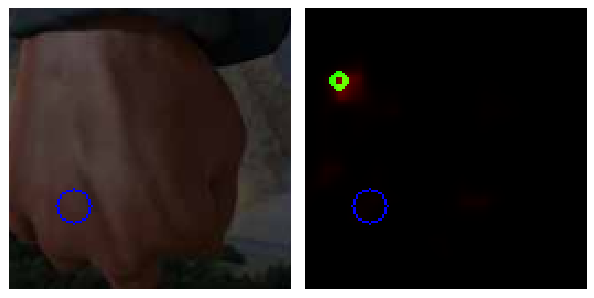

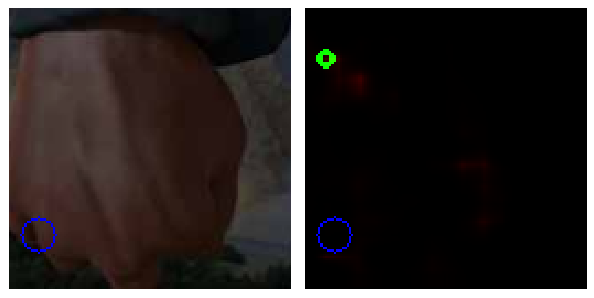

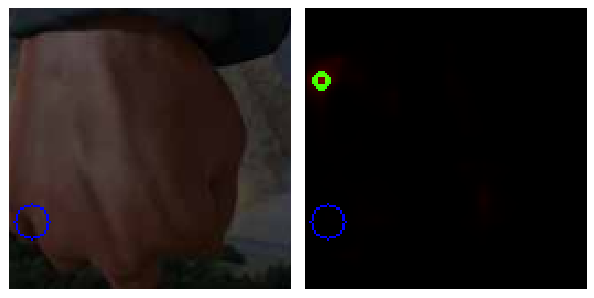

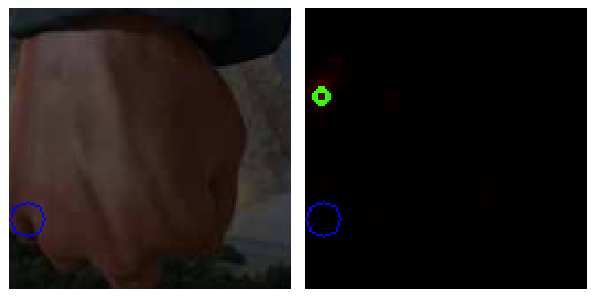

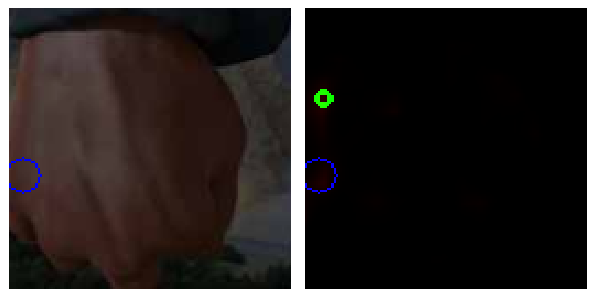

In [39]:
with _init_graph(config, with_dataset=True) as (net, dataset):
    net.load(exper_dir, flexible_restore=False);
    data = dataset.get_validation_set()
    for _ in range(6):
        d = next(data)
        keypoints = d['keypoints']
        p = net.predict(d, keys='*')
        expectations = p['p_max']
        logits = p['logits']
        
        #plt.figure(figsize=(15,30))
        for joint in range(logits.shape[2]):
            activation_map = process_logits(logits[:,:,joint])
            input_img = np.squeeze(d['image'])/255.
            diag_img = input_img
            diag_img = draw_disk(diag_img, keypoints[joint])
            diag_img = draw_keypoints(diag_img, expectations[joint], color=(0, 255, 0))
            diag_img = np.clip(diag_img + activation_map, 0., 1.)
            plot_imgs([np.clip(input_img, 0., 1.), diag_img], dpi=50)